# PREPROCESSING COLOSSEUM DATA TO LINKED DATA
In this notebook, we preprocess BIM, PCD and IMG data of the Colosseum to RDF Graphs.

>This codebase operates on the scan2bim2.yml environment (python 3.8) and ifcopenshell

In [427]:

#IMPORT PACKAGES
from rdflib import Graph, URIRef
import os.path
import importlib
import numpy as np
import xml.etree.ElementTree as ET
import open3d as o3d
import uuid    
import pye57 
import ifcopenshell
import ifcopenshell.geom as geom
import ifcopenshell.util
from ifcopenshell.util.selector import Selector
import random as rd
import pandas as pd
from tabulate import tabulate
import cv2
import laspy
import copy
from matplotlib import pyplot as plt
import math
#IMPORT MODULES
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.tools import progresstools as pt
from geomapi.utils import imageutils as iu

import geomapi.tools as tl

In [267]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
%autoreload 2

## USER INPUT

In [431]:

## INPUTS
projectPath= os.path.join("D:\\Data\\2023-01 Colosseum")
sessionPath = os.path.join(projectPath,"Research")

#BIM
bimPath=os.path.join(sessionPath,"BIM")
ifcPath=os.path.join(projectPath,'BIM','RMCO_S01_M3_4.ifc')
bimGraphPath = os.path.join(sessionPath,"BIM","bimGraph.ttl")
# bimSeperatorGraphPath = os.path.join(sessionPath,"BIM","bimSeperatorGraph.ttl")
# bimSeperators= {'LV-03_A':'3saOMnutrFHPtEwspUjESB',
#                 'Facade_1':'0H$kAf94TFru8CbHUTFppg',
#                 'LV-02.1_A':'3saOMnutrFHPtEwspUjEN8',
#                 'LV-02_A':'3saOMnutrFHPtEwspUjEHi',
#                 'LV-01_A':'3saOMnutrFHPtEwspUjEJs',
#                 'LV-02_B':'3saOMnutrFHPtEwspUjEjK',
#                 'LV-01_B': '3saOMnutrFHPtEwspUjEZ6',
#                 'LV-01_C': '3saOMnutrFHPtEwspUjEXN'}

#PCD
# csvPath=os.path.join(projectPath,'PCD','2022_11_09_RMCO_SE01-01_unito_V2.csv')#os.path.join(projectPath,'PCD','COLOSSEO_UNITO_test3.csv')
lasPath=os.path.join(projectPath,"PCD","COLOSSEO_UNITO_test4 - Cloud - classes.las")
pcdGraphPath=os.path.join(sessionPath,"PCD","pcdGraph.ttl")
clusteredPcdGraphPath=os.path.join(sessionPath,"PCD","clusteredPcdGraph.ttl")
pcdDirectory=os.path.join(sessionPath,"PCD")
# materialPcdGraphPath=os.path.join(sessionPath,"PCD","materialPcdGraph.ttl")
# segmentedPcdGraphPath=os.path.join(sessionPath,"PCD","segmentedPcdGraph.ttl")


#IMG
xmlPath=os.path.join(projectPath,'Research','IMG','cameras.xml')
imgGraphPath=os.path.join(sessionPath,"IMG","imgGraph.ttl")
pixelWidth=0.0060975609756097563
f= 2668.8837741268403
pixelRange=224
#offset
transform=np.array([[1.0,0.0, 0.0, -2.3119001244394034e+06 ], 
                [0.0, 1.0, 0.0, -4.6406591797101609e+06],
                [0.0, 0.0, 1.0 ,-2.5068223291342328e+01],
                [0.0 ,0.0, 0.0, 1.000000000000]])
bimTransform=np.array([[1.0,0.0, 0.0, -2.3119001244394034e+06  ], 
                [0.0, 1.0, 0.0, -4.6406591797101609e+06],
                [0.0, 0.0, 1.0 ,0],
                [0.0 ,0.0, 0.0, 1.000000000000]])

# Segmentation
# listgrouping=["M", "D", "TC", "Index"]
listgrouping=['01 Materiali', '02 TC', '03 D']
listnames=['material','buildingTechnique','damage']
dbclustering=0.05
mimimalclustersize=10

## PARSE BIM,PCD AND IMAGES & CREATE NODES
A set of nodes is created for the ifc, pcd and img objects

In [19]:
#BIMNODES
bimNodes=tl.ifc_to_nodes_multiprocessing(ifcPath,offsetTransform=transform)
saved=[n.save_resource(bimPath) for n in bimNodes]
for n in bimNodes:
    # n.cartesianTransform= bimTransform @ transform
    n.resource.transform(transform)
print(str(len(saved))+ " BIMNodes created and saved!")

[Open3D WARNING] Write PLY failed: unable to open file: D:/Data/2023-01 Colosseum/Research/BIM/SPP_FamigliaSupporto_001:SPP_MarkerRiferimento_GN-00_001:132086.ply
[Open3D WARNING] Write PLY failed: unable to open file: D:/Data/2023-01 Colosseum/Research/BIM/PIL_Valadier_001:PIL_Valadier_PT_03-LT01_001:342323.ply
[Open3D WARNING] Write PLY failed: unable to open file: D:/Data/2023-01 Colosseum/Research/BIM/PIL_Valadier_001:PIL_Valadier_PT_03-LT01_001:342986.ply
[Open3D WARNING] Write PLY failed: unable to open file: D:/Data/2023-01 Colosseum/Research/BIM/PIL_Generico_001:PIL_Ambulacro_PT-03_002:343944.ply
[Open3D WARNING] Write PLY failed: unable to open file: D:/Data/2023-01 Colosseum/Research/BIM/PIL_Generico_001:PIL_Ambulacro_PT-03_002:344093.ply
[Open3D WARNING] Write PLY failed: unable to open file: D:/Data/2023-01 Colosseum/Research/BIM/PIL_Generico_001:PIL_Ambulacro_PT-03_002:344158.ply
[Open3D WARNING] Write PLY failed: unable to open file: D:/Data/2023-01 Colosseum/Research/BIM

In [174]:
#PCDNODES
las  = laspy.read(lasPath)
pcd=gmu.las_to_pcd(las,transform=transform)
pcdNode=PointCloudNode(name=ut.get_filename(lasPath),
                        lasPath=lasPath,
                        resource=pcd,
                        offsetTransform=transform)
saved=pcdNode.save_resource(pcdDirectory)
print("PointCloudNode " + pcdNode.subject +  " created!")

PointCloudNode file:///COLOSSEO_UNITO_test4_-_Cloud_-_classes does not look like a valid URI, trying to serialize this will break.
PointCloudNode file:///COLOSSEO_UNITO_test4_-_Cloud_-_classes created! does not look like a valid URI, trying to serialize this will break.


PointCloudNode file:///COLOSSEO_UNITO_test4_-_Cloud_-_classes created!


In [ ]:
#PCDNODES (as pd)
# df = pd.read_csv(csvPath,
#     sep= ' ',
#     header=0,  
#     names=["x","y","z","R", "G", "B", "M", "TC", "Nx", "Ny", "Nz" ]) #["x","y","z","R", "G", "B", "M", "D", "TC", "Index", "Nx", "Ny", "Nz" ]
# print(df.head()) 
# # pcd=gmu.dataframe_to_pcd(df,transform=transform)
# # pcdNode=PointCloudNode(name=ut.get_filename(csvPath),
# #                         csvPath=csvPath,
# #                         resource=pcd,
# #                         offsetTransform=transform)
# # saved=pcdNode.save_resource(pcdDirectory)
# # print("PointCloudNode " + pcdNode.subject +  " created!")

In [234]:
#IMGNODES
imgNodes=tl.img_xml_to_nodes(xmlPath)
imgNodes=[n for n in imgNodes if n.cartesianTransform is not None and n.path is not None and os.path.exists(n.path)]
for n in imgNodes:
    rotation=np.array([[4.1458532257958308e-01, 9.0392097872801924e-01 ,-1.0509935545455225e-01,0],
                        [ 9.0916313459383069e-01, -4.1641033853698489e-01, 4.9824346492534097e-03,0],
                        [-3.9260730980247453e-02, -9.7618103725144317e-02, -9.9444924497331855e-01,0],
                        [0,0,0,1]])
    n.cartesianTransform=rotation @ n.cartesianTransform
    n.offsetTransform=transform
    n.focalLength35mm=f
    n.pixelWidth=pixelWidth
    # n.focalLength35mm=f
    # n.pixelWidth=pixelWidth
meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]

print(str(len(imgNodes))+ " Nodes created!")

84 Nodes created!


In [235]:
joinedImages=gmu.join_geometries(meshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
joinedBIM=gmu.join_geometries([n.resource for n in bimNodes if n.resource])
o3d.visualization.draw_geometries([joinedImages]+[pcdNode.resource])

In [144]:
# o3d.io.write_triangle_mesh(os.path.join(projectPath,'Research','IMG','meshes.obj'),joinedImages)

True

In [22]:
# geometries=[node.resource for node in imgNodes if node.resource]
# o3d.visualization.draw_geometries(geometries)

**Fig.**: Overview of the (a) point cloud (11MM points) with materials, damage and building technique classes, (b) BIM (550 geometric elements) and (c) some 900 images.

<img src="../docs/pics/colosseum/pcd1.PNG" width = "35%">
<img src="../docs/pics/colosseum/columns1.PNG" width = "22%">
<img src="../docs/pics/colosseum/IMG2.PNG" width = "25%">
<img src="../docs/pics/colosseum/DSC03537.JPG" width = "13%">

In [232]:
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': 'D:\\Data\\2023-01 Colosseum\\Research\\IMG\\cameras.xml',
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 3936,
 'imageHeight': 2624,
 'focalLength35mm': None,
 '_subject': rdflib.term.URIRef('file:///DSC03407'),
 '_graph': <Graph identifier=N0a9d7510b8c344968f82d03c203b7fb8 (<class 'rdflib.graph.Graph'>)>,
 '_graphPath': 'D:\\Data\\2023-01 Colosseum\\Research\\IMG\\imgGraph.ttl',
 '_path': 'D:/Data/2023-01 Colosseum/Research/IMG/DSC03407.JPG',
 '_name': 'DSC03407',
 '_timestamp': '2022-05-06T09:49:24',
 '_resource': None,
 '_cartesianTransform': array([[-0.75025851, -0.585026  ,  0.30798822, -9.76861619],
        [ 0.66055085, -0.64354587,  0.38667982, 26.72716154],
        [-0.0280132 ,  0.49355171,  0.86926519,  0.06372214],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'resolutionUnit': 2,
 'offsetTransform': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -2.31190012e+06],
        [ 0.00000000e+00,  1.00000000e+

## RDF GRAPHS
An RDF graph and .ttl file is created for all nodes 
(data itself is not stored in the graph, only metadata)

In [236]:
bimGraph=tl.nodes_to_graph(bimNodes,bimGraphPath,save=True)
print (str(len(bimNodes))+' Nodes succesfully serialized in: '+bimGraphPath)

# bimSeperatorGraph=to.nodes_to_graph(bimSeperatorNodes,bimSeperatorGraphPath,save=True)
# print (str(len(bimSeperatorNodes))+' Nodes succesfully serialized in: '+bimSeperatorGraphPath)

pcdGraph=pcdNode.to_graph(pcdGraphPath,save=True)
print ('PCDNodes succesfully serialized in: '+pcdGraphPath)

imgGraph=tl.nodes_to_graph(imgNodes,imgGraphPath,save=True)
print (str(len(imgNodes))+' imgNodes succesfully serialized in: '+imgGraphPath)

719 Nodes succesfully serialized in: D:\Data\2023-01 Colosseum\Research\BIM\bimGraph.ttl
PCDNodes succesfully serialized in: D:\Data\2023-01 Colosseum\Research\PCD\pcdGraph.ttl
84 imgNodes succesfully serialized in: D:\Data\2023-01 Colosseum\Research\IMG\imgGraph.ttl


## (optionally) LOAD RDF GRAPHS

In [ ]:
pcdNode=tl.graph_path_to_nodes(graphPath=pcdGraphPath,getResource=True)[0]
print(str(len(ut.item_to_list(pcdNode))) + ' pcdNode')
clusteredpcdNodes=tl.graph_path_to_nodes(graphPath=clusteredPcdGraphPath,getResource=True)
print(str(len(clusteredpcdNodes)) + ' clusteredpcdNodes')
imgNodes=tl.graph_path_to_nodes(graphPath=imgGraphPath,getResource=True,getMetaData=False)
print(str(len(imgNodes)) + ' imgNodes')

## CREATE IMAGE TRAINING SAMPLES FROM POINT CLOUD DATA
Print unique values per material (M), damage (D) and building technique (TC)

In [176]:
print(np.unique(las['01 Materiali']))
print(np.unique(las['02 TC']))
print(np.unique(las['03 D']))

[0. 1. 4.]
[0. 1. 2. 3. 6. 7. 8.]
[0. 1. 2. 3.]


In [19]:
#(optional) pandas dataframe
# print(df.M.unique())
# print(df.D.unique())
# print(df.TC.unique())

[0. 1. 4.]
[1. 2. 3. 0.]
[0. 2. 8. 3.]
[0. 3.]


**Fig.**: Image of the (a) Original point cloud, (b) Materials, (c) Damages and (d) Building Techniques

<img src="../docs/pics/colosseum/Facade1.PNG" width = "49%">
<img src="../docs/pics/colosseum/Mat1.PNG" width = "49%">
<img src="../docs/pics/colosseum/D1.PNG" width = "49%">
<img src="../docs/pics/colosseum/TC1.PNG" width = "49%">


Raytrace point cloud from image locations, subdivide the images and assign the information to imgTrainingNodes

In [419]:
point_cloud=copy.deepcopy(pcdNode.resource)
imgTrainingNodes=[]

for listgroup in listgrouping[0:1]: #'01 Materiali', '02 TC', '03 D'
    
    #create colors per class
    classes=np.unique(las[listgroup])
    # colors=np.array([ut.random_color() for v in range(len(classes))])
    colors=np.array([[0,255,0],[255,0,0],[0,0,255]])
    grayColors=iu.rgb2gray(colors)/255
    classes=np.append(classes,-1)

    #assign colors to point cloud
    colorArray=gmu.array_to_colors(las[ listgroup],colors)
    point_cloud.colors=o3d.utility.Vector3dVector(colorArray)
    for n in imgNodes[0:9]:
        #raytrace scene
        # ! the pcd is to sparce. from 10m+ the rays dont find the points anymore. can we do this for a voxelgrid?
        colorImage,depthImage=pt.project_pcd_to_rgbd_images(point_cloud,n,depth_max=20)
        imgList,roiList=iu.subdivide_image(n.resource,width=pixelRange,height=pixelRange,includeLast=False)
        classImgList,_=iu.subdivide_image(iu.rgb2gray(colorImage[0]),width=pixelRange,height=pixelRange,includeLast=False)
        
        for img,roi,cimg in zip(imgList,roiList,classImgList):
            # remove 0 pixels

            values, counts = np.unique(cimg, return_counts=True) 
            i_0=values.tolist().index(0.0)
            values=np.delete(values, i_0)
            counts=np.delete(counts, i_0)
            
            if counts.shape[0]>0:
                i = np.argmax(counts)
                index = grayColors.tolist().index(values[i]) if any(values[i]==c for c in grayColors) else -1 
            else:
                index=-1  
            # assign information to imgTrainingNodes   
            node=ImageNode(resource=img,
                                isDerivedFrom=n.subject,
                                roi=roi)
            setattr(node,listgroup, classes[index])
            imgTrainingNodes.append(node) 
print(len(imgTrainingNodes))

1683


In [426]:

# # img=cv2.resize(n.resource, (math.ceil(n.resource.shape[1]/16),math.ceil(n.resource.shape[0]/16)))
# fig, axs = plt.subplots(1, 3,figsize=(20, 20))
# fig.set_facecolor("white")
# axs[0].imshow(imgTrainingNodes[-1].resource)
# axs[1].imshow(imgTrainingNodes[-1].valueimage)
# axs[2].imshow(colorImage[0]) 

# plt.show()

Visualize training samples

In [420]:
# recompile images
images=[]
for n in imgNodes[0:9]:
    image=copy.deepcopy(n.resource)
    # select nodes
    nodeList=[tn for tn in imgTrainingNodes if tn.isDerivedFrom ==n.subject]
    #create mask from roi
    for i,c in enumerate(classes):
                roiList= [t.roi for t in nodeList if getattr(t,listgroup)==i]
        if len(roiList) >0:
            for roi in roiList:
                roi=image[roi[0]:roi[1],roi[2]:roi[3]] 
                roi[:,:,:]=colors[i]
    images.append(image)   


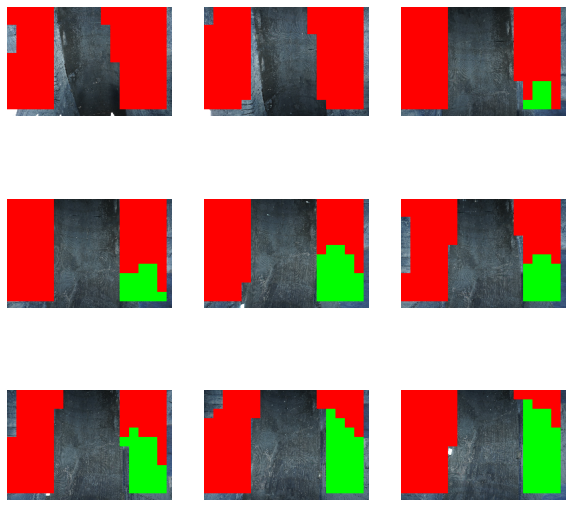

In [430]:
fig=plt.figure(figsize=(10, 10))
fig.set_facecolor("white")

for i,img in enumerate(images[0:9]):
    ax = plt.subplot(3, 3, i + 1,)
    plt.imshow(cv2.resize(img, (math.ceil(img.shape[1]/16),math.ceil(img.shape[0]/16))))
    
    plt.axis("off")

In [ ]:
{key:value for key, value in imgTrainingNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

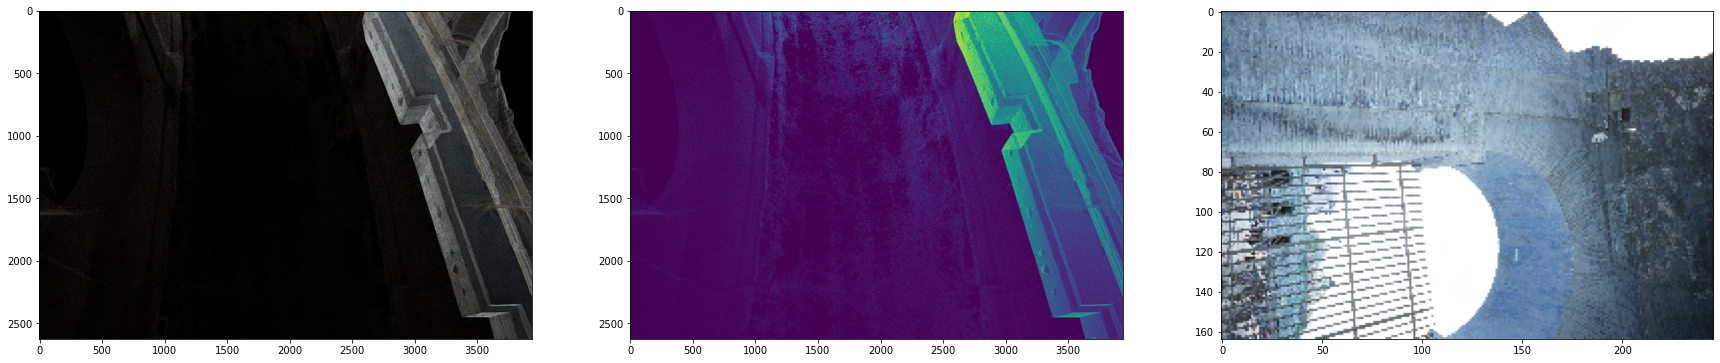

In [274]:
from matplotlib import pyplot as plt
import math
img=cv2.resize(n.resource, (math.ceil(n.resource.shape[1]/16),math.ceil(n.resource.shape[0]/16)))
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
fig.set_facecolor("white")
axs[0].imshow(colorImage[0])
axs[1].imshow(depthImage[0])
axs[2].imshow(img) 

plt.show()

## CREATE TRAINING SAMPLES FROM THE BIM ALSO

## CLUSTER PCD BY CONVEX HULL

Split dataframe per unique material (M), damage (D) and building technique (TC) into point clouds (takes 20s for 3M points and 2800 pcds)

In [ ]:
# # DATAFRAME technique
# pcds=[]
# names=[] 
# for name,group in df.groupby(listgrouping):
#     names.append(name)
#     pcd=gmu.dataframe_to_pcd(df=group,pointFields=['x', 'y', 'z','R', 'G', 'B','Nx', 'Ny', 'Nz'],transform=transform)
#     pcds.append(pcd)
# print(len(pcds))
# lengths=[len(pcd.points) for pcd in pcds]
# print(sum(lengths))

In [39]:
pcds=[]
names=[] 
for name in listgrouping:
    classes=np.unique(las[name])
    for c in classes:
        pcds.append(pcdNode.resource.select_by_index(np.where(las[name]==c)[0]))
        names.append(name)
        
print(len(pcds))
lengths=[len(pcd.points) for pcd in pcds]
print(sum(lengths))

11
10272150


Report biggest cluster

In [15]:
print(lengths.index(max(lengths)))
pcd=pcds[5]

5


Segment each pcd in connected components (retain names). 45s for 220 clusters, 5cm , 3M points

In [22]:
clusteredPcds=[]
clusteredNames=[]
colors=[]
for i,pcd in enumerate(pcds):    
    if len(pcd.points)>mimimalclustersize:
        list=gmu.segment_pcd_by_connected_component(pcd, eps=dbclustering)
        clusteredPcds.extend(list)
        color=[rd.random(),rd.random(),rd.random()]
        for l in range(len(list)):
            clusteredNames.append(names[i]+tuple(ut.item_to_list(l)))
            colors.append(color)
print(len(clusteredPcds))

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 34
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 7
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 93
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 10
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBU

visualize points clouds in seperate colors

In [31]:
coloredPcds=[pcd.paint_uniform_color([rd.random(),rd.random(),rd.random()]) for pcd in clusteredPcds]
joined=gmu.join_geometries(coloredPcds)
o3d.visualization.draw_geometries([joined])

**Fig.**: Image of the (a) clustering per D,TC,M and Index (17 clusters) and (b) clustering per connected component (eps=0.05m, 220 clusters)

<img src="../docs/pics/colosseum/segmented_1.PNG" width = "40%">
<img src="../docs/pics/colosseum/cluster2.PNG" width = "35%">

Create clusteredpcdNodes of clusteredPcds

In [23]:
clusteredpcdNodes=[]
for i,pcd in enumerate(clusteredPcds):
    material=listgrouping[0]+str(clusteredNames[i][0])
    damage=listgrouping[1]+str(clusteredNames[i][1])
    buildingTechnique=listgrouping[2]+str(clusteredNames[i][2])
    originalCloudIndex=listgrouping[3]+str(clusteredNames[i][3])
    name=material+damage+buildingTechnique+originalCloudIndex+'Part'+str(clusteredNames[i][4])
    clusteredpcdNodes.append(PointCloudNode(name=name,
                                            resource=pcd,
                                            isDirivedFrom=pcdNode.subject,
                                            offsetTransform=transform,
                                            color=colors[i],
                                            material=clusteredNames[i][0],
                                            damage=clusteredNames[i][1],
                                            buildingTechnique=clusteredNames[i][2],
                                            originalCloudIndex=clusteredNames[i][3]))
print(len(clusteredpcdNodes))

212


Buffer resources on hard drive

In [24]:
saved=[n.save_resource(directory=pcdDirectory) for n in clusteredpcdNodes]
print(str(len(saved))+ " Nodes created and saved!")

212 Nodes created and saved!


In [325]:
{key:value for key, value in imgTrainingNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 224,
 'imageHeight': 224,
 'focalLength35mm': None,
 '_subject': rdflib.term.URIRef('file:///b77defb2-a0ac-11ed-ab51-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': 'b77defb2-a0ac-11ed-ab51-c8f75043ce59',
 '_timestamp': None,
 '_resource': array([[[ 54,  70,  93],
         [ 52,  69,  90],
         [ 59,  76,  97],
         ...,
         [ 62,  82, 100],
         [ 62,  82, 100],
         [ 68,  88, 106]],
 
        [[ 51,  67,  90],
         [ 57,  74,  95],
         [ 61,  78,  99],
         ...,
         [ 61,  81,  99],
         [ 61,  81,  99],
         [ 65,  85, 103]],
 
        [[ 50,  67,  88],
         [ 61,  78,  99],
         [ 61,  78,  99],
         ...,
         [ 61,  81,  99],
         [ 61,  81,  99],
         [ 58,  78,  96]],
 
        ...,
 
        [[ 56,  68,  92],
         [ 57,  71,  94],
         [ 65,  79, 102],
         ...,
         [ 71,  94,

Create RDF graph of ClusteredPcdNodes

In [25]:
clusteredPcdGraph=to.nodes_to_graph(clusteredpcdNodes,clusteredPcdGraphPath,save=True)
print (str(len(clusteredpcdNodes))+' Nodes succesfully serialized in: '+clusteredPcdGraphPath)

212 Nodes succesfully serialized in: D:\Data\2023-01 Colosseum\Research\PCD\clusteredPcdGraph.ttl


# SEGMENT POINT CLOUDS WITH BIMSEPERATORS

## Segment point clouds (optional)

In [39]:
meshes=[n.resource for n in bimSeperatorNodes if n.resource]
croppedPcds, indices=gmu.crop_point_cloud_from_meshes(pcdNode.resource,meshes)
headers = ['Name', 'pcd']   
names=[n.name for n in bimSeperatorNodes] 
print(tabulate(zip(names,croppedPcds), headers=headers, floatfmt=".4f"))

Name                         pcd
---------------------------  ------------------------------
Facade_1:Facade_1:2415694    PointCloud with 188773 points.
LV-01_A:LV-01_A:2418239      PointCloud with 153186 points.
LV-01_B:LV-01_B:2419215
LV-01_C:LV-01_C:2419358
LV-02.1_A:LV-02.1_A:2418433
LV-02_A:LV-02_A:2418341
LV-02_S:LV-02_B:2419101
LV-03_A:LV-03_A:2418114


In [ ]:
paintedPCD=[pcd for pcd in croppedPcds if pcd is not None]
paintedPCD=[pcd.paint_uniform_color([rd.random(),rd.random(),rd.random()]) for pcd in paintedPCD if pcd is not None]
paintedPCD=gmu.join_geometries(paintedPCD)
o3d.visualization.draw_geometries([bimSeperatorLineSet]+[paintedPCD])

Create direvative segmentedPcdNodes for every segment

In [ ]:
segmentedPcdNodes=[]
for n,pcd in zip(bimSeperatorNodes,croppedPcds):
    if pcd:
        segmentedPcdNodes.append(PointCloudNode(subject=n.subject,
                                                name=n.name,
                                                resource=pcd,
                                                isDerivedFromGeometry=pcdNode.subject,
                                                analysisTimestamp=pcdNode.timestamp))
saved=[n.save_resource(pcdDirectory) for n in segmentedPcdNodes]
print(str(len(saved))+ " segmentedPcdNodes created and saved!")

segmentedPcdGraph=to.nodes_to_graph(segmentedPcdNodes,segmentedPcdGraphPath,save=True)
print (str(len(segmentedPcdNodes))+' Nodes succesfully serialized in: '+segmentedPcdGraphPath)

## Segment dataframes

In [8]:
newDf=gmu.transform_dataframe(df,transform)
dataframes=gmu.crop_dataframe_from_meshes(newDf,meshes)
headers = ['Name', 'pcd']   
names=[n.name for n in bimSeperatorNodes] 
lengths=[len(list) if list is not None else None for list in dataframes ]
print(tabulate(zip(names,lengths), headers=headers, floatfmt=".4f"))

MemoryError: Unable to allocate 27.2 GiB for an array with shape (11, 331990927) and data type float64

In [55]:
paintedPCD=[gmu.dataframe_to_pcd(df) for df in dataframes if df is not None]
paintedPCD=[pcd.paint_uniform_color([rd.random(),rd.random(),rd.random()]) for pcd in paintedPCD if pcd is not None]
paintedPCD=gmu.join_geometries(paintedPCD)
o3d.visualization.draw_geometries([bimSeperatorLineSet]+[paintedPCD])

In [78]:
names=[ut.get_filename(n.subject) for n in bimSeperatorNodes] 
for name,df in zip(names,dataframes):
    if df is not None:
        print( f' {name}.ply saved ')
        gmu.save_dataframe_as_ply(os.path.join(pcdDirectory,name), points=df,as_text=True)

 Facade_1_Facade_1_2415694_0H_kAf94TFru8CbHUTFppg.ply saved 
 LV-01_A_LV-01_A_2418239_3saOMnutrFHPtEwspUjEJs.ply saved 
 LV-01_B_LV-01_B_2419215_3saOMnutrFHPtEwspUjEZ6.ply saved 
 LV-01_C_LV-01_C_2419358_3saOMnutrFHPtEwspUjEXN.ply saved 
 LV-02.ply saved 
 LV-02_A_LV-02_A_2418341_3saOMnutrFHPtEwspUjEHi.ply saved 
 LV-02_S_LV-02_B_2419101_3saOMnutrFHPtEwspUjEjK.ply saved 
 LV-03_A_LV-03_A_2418114_3saOMnutrFHPtEwspUjESB.ply saved 


Create direvative segmentedPcdNodes for every segment

In [80]:
segmentedPcdNodes=[]
for n,df in zip(bimSeperatorNodes,dataframes):
    if df is not None:
        segmentedPcdNodes.append(PointCloudNode(subject=n.subject,
                                                name=n.name,
                                                csvPath=os.path.join(pcdDirectory,ut.get_filename(n.subject)),
                                                isDerivedFromGeometry=pcdNode.subject,
                                                analysisTimestamp=pcdNode.timestamp))
segmentedPcdGraph=to.nodes_to_graph(segmentedPcdNodes,segmentedPcdGraphPath,save=True)
print (str(len(segmentedPcdNodes))+' Nodes succesfully serialized in: '+segmentedPcdGraphPath)

2 Nodes succesfully serialized in: D:\Data\2023-01 Colosseum\Research\PCD\segmentedPcdGraph.ttl


# IMPORT RDF graphs 

Import clusteredpcdNodes, imgNodes and bimNodes

In [2]:
pcdNode=to.graph_path_to_nodes(graphPath=pcdGraphPath,getResource=True)[0]
print(str(len(ut.item_to_list(pcdNode))) + ' pcdNode')
clusteredpcdNodes=to.graph_path_to_nodes(graphPath=clusteredPcdGraphPath,getResource=True)
print(str(len(clusteredpcdNodes)) + ' clusteredpcdNodes')
imgNodes=to.graph_path_to_nodes(graphPath=imgGraphPath,getResource=True,getMetaData=False)
print(str(len(imgNodes)) + ' imgNodes')
# bimNodes=to.graph_path_to_nodes(graphPath=bimGraphPath,getResource=True)
# print(str(len(bimNodes)) + ' bimNodes')
bimSeperatorNodes=to.graph_path_to_nodes(graphPath=bimSeperatorGraphPath,getResource=True)
print(str(len(bimSeperatorNodes)) + ' bimSeperatorNodes')

NameError: name 'to' is not defined

# EXTRACT LOCAL AND GLOBAL FEATURES

Extract local + covariance features per observation

In [12]:
featurepcdNodes=[]
for n in clusteredpcdNodes:#
    if n.resource:
        uvratios=[n.orientedBoundingBox.extent[0]/n.orientedBoundingBox.extent[1],
                n.orientedBoundingBox.extent[1]/n.orientedBoundingBox.extent[2],
                n.orientedBoundingBox.extent[0]/n.orientedBoundingBox.extent[2]] 
        n.get_oriented_bounding_box() 
        _,covarianceMatrix=n.resource.compute_mean_and_covariance()
        eigenValues,eigenVectors=np.linalg.eig(covarianceMatrix)
        featurepcdNodes.append(Node(subject=n.subject,                                           
                                                volume=n.orientedBoundingBox.volume() ,                                           
                                                minUvRatio=min(uvratios),
                                                maxUvRatio=max(uvratios),
                                                eigenValues=eigenValues,
                                                eigenVectors=eigenVectors))  
    

Report features per Damage, Material, Building Technique.

In [37]:
print(df.M.unique())
print(df.D.unique())
print(df.TC.unique())
print(df.Index.unique())

[0. 1. 4.]
[1. 2. 3. 0.]
[0. 2. 8. 3.]
[0. 3.]


In [34]:
for i in df.M.unique():
    list=[n for n in clusteredpcdNodes if n.material==i and n.resource]
    print( 'material ' + str(i) + ' : ' + str(len(list)) + 
            '    avg. size: '+str(np.mean([n.volume for n in list])) +
            '    avg. min uv ratio: '+str(np.mean([n.minUvRatio for n in list])) +
            '    avg. max uv ratio: '+str(np.mean([n.maxUvRatio for n in list])) +
            '    avg. eigenValues: '+str([np.mean([n.eigenValues[0] for n in list]) ,np.mean([n.eigenValues[1] for n in list]) ,np.mean([n.eigenValues[2] for n in list]) ]  )  +
            '    avg. eigenVectors: '+str([np.mean([n.eigenVectors[0][2] for n in list]) ,np.mean([n.eigenVectors[1][2] for n in list]) ,np.mean([n.eigenVectors[2][2] for n in list]) ]  )    )


material 0.0 : 49    avg. size: 6.992178349779105    avg. min uv ratio: 2.0058211303711206    avg. max uv ratio: 10.837029687792734    avg. eigenValues: [0.19254290610283564, 0.10637257688300211, 0.2238820280292671]    avg. eigenVectors: [0.019803746084659717, -0.028345923953310093, 0.4474351093291564]
material 1.0 : 15    avg. size: 6.193488341128893    avg. min uv ratio: 1.6882490002120656    avg. max uv ratio: 9.387174730640488    avg. eigenValues: [0.5807895768764803, 0.1840488404081582, 0.08942777142017902]    avg. eigenVectors: [0.05728370671042169, -0.09368165967103441, 0.7063970588975464]
material 4.0 : 7    avg. size: 0.5196751800767835    avg. min uv ratio: 1.7872644012968248    avg. max uv ratio: 5.822612805653004    avg. eigenValues: [0.1724873867677556, 0.0033528768289794943, 0.027408282144226973]    avg. eigenVectors: [0.11091249796098121, 0.4756039943389136, 0.6333387616104835]


In [35]:
for i in df.D.unique():
        list=[n for n in clusteredpcdNodes if n.damage==i and n.resource]
        print( 'damage ' + str(i) + ' : ' + str(len(list)) + 
            '    avg. size: '+str(np.mean([n.volume for n in list])) +
            '    avg. min uv ratio: '+str(np.mean([n.minUvRatio for n in list])) +
            '    avg. max uv ratio: '+str(np.mean([n.maxUvRatio for n in list])) +
            '    avg. eigenValues: '+str([np.mean([n.eigenValues[0] for n in list]) ,np.mean([n.eigenValues[1] for n in list]) ,np.mean([n.eigenValues[2] for n in list]) ]  )  +
            '    avg. eigenVectors: '+str([np.mean([n.eigenVectors[0][2] for n in list]) ,np.mean([n.eigenVectors[1][2] for n in list]) ,np.mean([n.eigenVectors[2][2] for n in list]) ]  )    )

damage 1.0 : 16    avg. size: 6.203450298797019    avg. min uv ratio: 1.7381718222715161    avg. max uv ratio: 14.49004844098182    avg. eigenValues: [0.24589185357503823, 0.08860796518485654, 0.31019705735931763]    avg. eigenVectors: [0.036148860834806645, -0.19544598426677326, 0.6765455220358342]
damage 2.0 : 51    avg. size: 6.609536109655487    avg. min uv ratio: 1.9922615559254477    avg. max uv ratio: 9.105264074763802    avg. eigenValues: [0.29341901408118426, 0.12869327217749155, 0.14474530969870886]    avg. eigenVectors: [0.030122412733993506, 0.04719403038823629, 0.45939313748081884]
damage 3.0 : 4    avg. size: 0.7038110358662447    avg. min uv ratio: 1.6759331729754008    avg. max uv ratio: 4.0927806080898534    avg. eigenValues: [0.11380459605485724, 0.003843671795639385, 0.039582551840782]    avg. eigenVectors: [0.12285045543523632, 0.31382324751575136, 0.6749673019425328]
damage 0.0 : 0    avg. size: nan    avg. min uv ratio: nan    avg. max uv ratio: nan    avg. eigenV

c:\Users\u0094523\.conda\envs\pyntcloud1\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\u0094523\.conda\envs\pyntcloud1\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
for i in df.TC.unique():
        list=[n for n in clusteredpcdNodes if n.buildingTechnique==i and n.resource]
        print( 'buildingTechnique ' + str(i) + ' : ' + str(len(list)) + 
            '    avg. size: '+str(np.mean([n.volume for n in list])) +
            '    avg. min uv ratio: '+str(np.mean([n.minUvRatio for n in list])) +
            '    avg. max uv ratio: '+str(np.mean([n.maxUvRatio for n in list])) +
            '    avg. eigenValues: '+str([np.mean([n.eigenValues[0] for n in list]) ,np.mean([n.eigenValues[1] for n in list]) ,np.mean([n.eigenValues[2] for n in list]) ]  )  +
            '    avg. eigenVectors: '+str([np.mean([n.eigenVectors[0][2] for n in list]) ,np.mean([n.eigenVectors[1][2] for n in list]) ,np.mean([n.eigenVectors[2][2] for n in list]) ]  ))

buildingTechnique 0.0 : 45    avg. size: 6.84344541192538    avg. min uv ratio: 2.0266653739170812    avg. max uv ratio: 11.081057318995382    avg. eigenValues: [0.2014726855754441, 0.07826292706225374, 0.22344665551905152]    avg. eigenVectors: [0.029839843479907993, -0.03060088174959189, 0.40331469915793744]
buildingTechnique 2.0 : 15    avg. size: 6.193488341128893    avg. min uv ratio: 1.6882490002120656    avg. max uv ratio: 9.387174730640488    avg. eigenValues: [0.5807895768764803, 0.1840488404081582, 0.08942777142017902]    avg. eigenVectors: [0.05728370671042169, -0.09368165967103441, 0.7063970588975464]
buildingTechnique 8.0 : 7    avg. size: 0.5196751800767835    avg. min uv ratio: 1.7872644012968248    avg. max uv ratio: 5.822612805653004    avg. eigenValues: [0.1724873867677556, 0.0033528768289794943, 0.027408282144226973]    avg. eigenVectors: [0.11091249796098121, 0.4756039943389136, 0.6333387616104835]
buildingTechnique 3.0 : 4    avg. size: 8.665423900633543    avg. mi

In [28]:
{key:value for key, value in featurepcdNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_subject': rdflib.term.URIRef('file:///M0.0D1.0TC0.0Index0.0Part0'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': None,
 '_timestamp': None,
 '_resource': None,
 '_cartesianTransform': None,
 'volume': 88.04531473304577,
 'minUvRatio': 1.7781867064468444,
 'maxUvRatio': 3.1895378265000764,
 'eigenValues': array([0.15137381, 0.71944061, 3.69079508]),
 'eigenVectors': array([[-0.98296018,  0.18290434,  0.01831103],
        [ 0.18226627,  0.95689229,  0.22613305],
        [-0.02383903, -0.22561726,  0.9739243 ]])}

Extract contextual features

# Generate Virtual Images

Colorize and merge point clouds

In [76]:
coloredPcds=[n.resource.paint_uniform_color(n.color) for n in clusteredpcdNodes]
joinedPcd=gmu.join_geometries(coloredPcds)

In [77]:
o3d.visualization.draw_geometries([joinedPcd]+meshes)

Generate virtual images of colorized point cloud https://github.com/isl-org/Open3D/issues/5049

In [78]:
cartesianTransforms=[n.cartesianTransform for n in imgNodes]
virtualImages=gmu.generate_virtual_images(joinedPcd ,cartesianTransforms,width=3936,height=2624,f=2668.88)
for i,n in enumerate(imgNodes):
    # gmu.generate_virtual_image(joinedPcd)
    n.virtualImg=virtualImages[i]
    o3d.io.write_image(os.path.join(sessionPath,"IMG_V", n.name +".PNG"), n.virtualImg)

**Fig.**: Image of the (a) geolocated images and (b) virtual images 

<img src="../docs/pics/colosseum/IMG2.PNG" width = "50%">
<img src="../docs/pics/colosseum/DSC03500.PNG" width = "30%">

Show Image position lines

In [ ]:
intrinsic_camera_parameters=n.get_intrinsic_camera_parameters()
lines=o3d.geometry.LineSet.create_camera_visualization(n.imageWidth,n.imageHeight,intrinsic_camera_parameters.intrinsic_matrix,n.cartesianTransform)
lines.paint_uniform_color([1,0,0])

# Generate classification images

colorize point cloud per material

In [7]:
# pcds=[]
# names=[] 
# for name,group in df.groupby(["M"]): 
#     names.append(name)
#     pcd=gmu.dataframe_to_pcd(df=group,pointFields=['x', 'y', 'z','R', 'G', 'B','Nx', 'Ny', 'Nz'])
#     pcd.transform(transform)
#     pcds.append(pcd)
# print(len(pcds))
# lengths=[len(pcd.points) for pcd in pcds]
# print(sum(lengths))

3
3424050


In [9]:
# materialPcdNodes=[]
# for i,pcd in enumerate(pcds):
#     materialPcdNodes.append(PointCloudNode(resource=pcd,
#                                             isDirivedFrom=pcdNode.subject,
#                                             offsetTransform=transform,
#                                             color=[rd.random(),rd.random(),rd.random()],
#                                             material=names[i]))
# materialPcdGraph=tl.nodes_to_graph(materialPcdNodes,materialPcdGraphPath,save=True)
# print (str(len(materialPcdNodes))+' Nodes succesfully serialized in: '+materialPcdGraphPath)

3 Nodes succesfully serialized in: D:\Data\2023-01 Colosseum\Research\PCD\materialPcdGraph.ttl


In [81]:
meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
joinedImages=gmu.join_geometries(meshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([joinedImages]+[pcdNode.resource])

Create raycasting scene and add point cloud convex hulls

In [82]:
clusteredpcdNodes=[n for n in clusteredpcdNodes if n.resource]
print(len(clusteredpcdNodes))
scene = o3d.t.geometry.RaycastingScene()

for n in clusteredpcdNodes:
    hull,_=n.resource.compute_convex_hull()
    n.hull=hull
    reference=o3d.t.geometry.TriangleMesh.from_legacy(hull)
    n.scene_id = scene.add_triangles(reference)
hullCenters=[n.hull.get_center() for n in clusteredpcdNodes]

71


In [109]:
test=clusteredpcdNodes[0].resource
hull,_=test.compute_convex_hull()
hulls=[n.hull for n in clusteredpcdNodes]
hulls=gmu.join_geometries(hulls)

print(hulls)
print(hull.is_watertight())

TriangleMesh with 2639 points and 4994 triangles.
True


In [104]:

scene = o3d.t.geometry.RaycastingScene()
reference=o3d.t.geometry.TriangleMesh.from_legacy(hulls)
scene_id = scene.add_triangles(reference)


False


Gather image properties

In [83]:
n=imgNodes[0]

range=10
imageWidth=n.imageWidth
imageHeight=n.imageHeight
virtualImageWidth=180
virtualImageHeight=180
focalLength35mm=n.focalLength35mm
print(n.cartesianTransform)

[[  0.49030671   0.39211761  -0.77835924 -16.88603593]
 [ -0.16572306   0.91872628   0.35843813  12.11720872]
 [  0.85564899  -0.04675255   0.51544059  -0.09577481]
 [  0.           0.           0.           1.        ]]


cast some rays (wrong distance, its to small)

In [102]:
# get directions for every window from pixel centers
bounds=[-0.25*imageWidth,0.25*imageWidth,
        -0.25*imageHeight, 0.25*imageHeight,
        focalLength35mm,focalLength35mm]
resolutions=[imageWidth/3,imageHeight/3,1]
grid=gmu.create_xyz_grid(bounds,resolutions)
points = np.reshape(grid.flatten(), (grid.shape[1]*grid.shape[2],3),order='F')

# # #transform to global coordinate system
directions=gmu.normalize_vectors(points)*9
# directions=points
directions=gmu.transform_points(directions,n.cartesianTransform)

# #create tensors
centers=np.tile(n.cartesianTransform[0:3,3],(len(points),1))
print(centers[0])
array=np.hstack((centers,directions))
print(array)
rays = o3d.core.Tensor(array,dtype=o3d.core.Dtype.Float32) 
ans = scene.cast_rays(rays)
distances=ans['t_hit'].numpy()
ids=ans['geometry_ids'].numpy()
print(distances)

print(ids)


[-16.88603593  12.11720872  -0.09577481]
[[-16.88603593  12.11720872  -0.09577481 -25.57117684  13.71120857
    1.64419411]
 [-16.88603593  12.11720872  -0.09577481 -23.95433802  13.09136424
    5.38967199]
 [-16.88603593  12.11720872  -0.09577481 -24.69095668  16.2832796
    1.55560817]
 [-16.88603593  12.11720872  -0.09577481 -22.99354465  15.79737763
    5.39555419]]
[inf inf inf inf]
[4294967295 4294967295 4294967295 4294967295]


determine distance to objects

In [80]:
#cast rays
# scene = o3d.t.geometry.RaycastingScene()
# reference=o3d.t.geometry.TriangleMesh.from_legacy(hulls)
# _ = scene.add_triangles(reference)
t=n.cartesianTransform[0:3,3]
print(t)
print(np.array([[t[0],t[1],t[2]]]))
query_points = o3d.core.Tensor(np.array([[t[0],t[1],t[2]]]), dtype=o3d.core.Dtype.Float32)

unsigned_distance = scene.compute_distance(query_points)
# indices=np.where((unsigned_distance.numpy() >=0.5*resolution) & (occupancy.numpy() ==0) )[0]     
print(unsigned_distance)


[-21.09520808  12.13572139   9.31897204]
[[-21.09520808  12.13572139   9.31897204]]
[0.0178132]
Tensor[shape={1}, stride={1}, Float32, CPU:0, 0x28085bd1580]


In [101]:
#show the hulls
hulls=[n.hull for n in clusteredpcdNodes]
hulls=gmu.join_geometries(hulls)
o3d.visualization.draw_geometries([hulls]+[joinedImages])


Create set of rays for every image (window size 180x180 px) given a gsd (average distance to objects)

In [36]:
# get directions for every window from pixel centers
bounds=[-imageWidth/2+virtualImageWidth/2,imageWidth/2-virtualImageWidth,
        -imageHeight/2+virtualImageHeight/2, imageHeight/2-virtualImageHeight,
        focalLength35mm,focalLength35mm]
resolutions=[virtualImageWidth,virtualImageHeight,1]
grid=gmu.create_xyz_grid(bounds,resolutions)
points = np.reshape(grid.flatten(), (grid.shape[1]*grid.shape[2],3),order='F')

# # #transform to global coordinate system
directions=gmu.normalize_vectors(points)*range
directions=gmu.transform_points(directions,n.cartesianTransform)
# #create tensors
centers=np.tile(n.cartesianTransform[0:3,3],(len(points),1))
array=np.hstack((centers,directions))
rays = o3d.core.Tensor(array,dtype=o3d.core.Dtype.Float32)  


visualize rays

In [96]:
allPoints=np.vstack((n.cartesianTransform[0:3,-1],directions))

lines=[]
lines = np.arange(start=1,stop=len(allPoints) )[..., np.newaxis]
lines = np.concatenate((np.zeros((len(directions),1)), lines), axis=1)

line_set = o3d.geometry.LineSet()
# colors = [[1, 0, 0] for i in range(len(lines))]
line_set.points = o3d.utility.Vector3dVector(allPoints)
line_set.lines = o3d.utility.Vector2iVector(lines)
# line_set.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([line_set]+[pcdNode.resource]+[joinedImages])


Split original images (bottom left to top right)

DSC03492
[   0.  180.  360.  540.  720.  900. 1080. 1260. 1440. 1620. 1800. 1980.
 2160. 2340. 2520. 2700. 2880. 3060. 3240. 3420. 3600. 3780.]
[2624. 2444. 2264. 2084. 1904. 1724. 1544. 1364. 1184. 1004.  824.  644.
  464.  284.  104.]


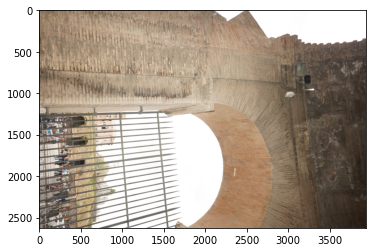

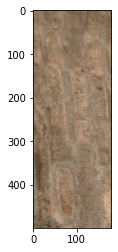

In [17]:
print(n.name)
im=n.resource
N=virtualImageWidth
M=virtualImageHeight
import matplotlib.pyplot as plt

print(np.arange(0,n.imageWidth,virtualImageWidth))
print(np.arange(n.imageHeight,0,-virtualImageHeight))
test=im[0:500,0:180]
image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
image = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
# tiles = [im[u:u-virtualImageHeight,v:v+virtualImageWidth] for v in np.arange(int(n.imageHeight),0,-virtualImageHeight) for u in np.arange(0,int(n.imageWidth),virtualImageWidth)]
# print(tiles)

# # tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
# cv2.imshow('image',tiles[0])
# cv2.imshow('image',tiles[-1])
# cv2.waitKey(0)

Cast rays and assign properties to image

In [175]:
print(o3d.t.geometry.RaycastingScene.INVALID_ID)

4294967295


In [38]:
ans = scene.cast_rays(rays)
ids=ans['geometry_ids'].numpy()
sceneIds=[n.scene_id for n in clusteredpcdNodes]
distances=ans['t_hit'].numpy()
print(distances)

print()


[       inf        inf        inf        inf        inf        inf
 0.26205853 0.20042397 0.18948868 0.18469353 0.18312947 0.18453279
 0.18647003 0.1880199  0.19045846 0.19310261 0.19592543 0.1988976
 0.201989   0.20516974 0.20841143        inf        inf        inf
        inf        inf        inf        inf        inf        inf
 0.2262494  0.1998229  0.19633454 0.1939838  0.19268131 0.19265784
 0.19479857 0.1974705  0.20043099 0.20363072 0.2070324  0.2105995
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
 0.24745628 0.21602584 0.21533218 0.21572559 0.21711265 0.21940729
 0.22252831 0.22640012 0.23095274        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf 0.3010157  0.2947165  0.294326
        inf        inf        inf        inf        inf        inf